# Importing Libraries and Cleaned Datasets

In [80]:
#import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels as sm

county_health_rank = pd.read_csv('county_rankings25.csv')
fips_codes = pd.read_csv('all_fips.csv')
county_vars = pd.read_csv('county_vars_2.csv')
ltss_2022 = pd.read_csv('ltss_2022.csv')

# Data Cleaning Plan
## County Health Rankings 2025
In place of the previousl 4 tables reporting socio economic metrics, I found a new Dataset 'County Health Rankings.' The data wrangling process will involve selecting the target variables, renaming, normalizing data types, validating the resulting dataframe, and applying the standardized hierarchical index (county, state).

Since dataset contains hundreds of variables, I created a small dataframe of our variables of interest and normalized names to facilate creating the subset itself and its naming conventions. 


## LTSS Enrollment and Expenditure tables
The state-level LTSS enrollment and expenditure tables remain and their cleaning involves: subsetting by columns neeeded reporting metrics for enrollment and expenses. These variables reflect enrollment in the first table and expenses in the second for (1)The entire LTSS program, (2) Institutional care, and (3)HCBS program. 

I will subset each table by thsese colums, rename by the conventions defined at the beginning of the section, remove invalid characters ('$', ',') from numeric columns, change the datatypes of the columns to floats for quantitative variables ans strings for 'id' variables, and set 'state' as index prior to merging.

## FIPS & States ID table
I will merge both tables above to a previosly created 'all_fips' (which serves as a sort of  'fact table'-listing county names, state names, state abbreviations, and corresponding fips codes) by index. 

I will validate the data and clean any merging errors like the creation of duplicate columns and/or changes to naming conventions (such as adding suffixes/prefixes to duplicate and original colums).

Finally, I will merge both of these new tables by the standardized index mentioned above.

# Data Cleaning

## LTSS Table

### Cleaning invalid characters in columns to prep for datatype conversion to float

In [100]:
# defining columns to keep and subsetting dataframes
ltss_cols= ['State', 'LTSS (total)']
ltss_population = ltss_2022[ltss_cols]

ltss_population['LTSS (total)'] = ltss_population['LTSS (total)'].str.replace(',', '').astype(float)
ltss_pop_names = {'State': 'state', 'LTSS (total)': 'ltss_state_enrollment'}
ltss_population = ltss_population.rename(columns=ltss_pop_names)
ltss_population.set_index(['state'])
# normalize state names
ltss_state_rename_enr = {'National': 'United States','District of\nColumbia':'District of Columbia'}
ltss_population['state'] = ltss_population['state'].replace(ltss_state_rename_enr)


/tmp/ipykernel_5328/2620598630.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ltss_population['LTSS (total)'] = ltss_population['LTSS (total)'].str.replace(',', '').astype(float)


## County Rankings tables

create subset, clean result, and merge with 'fips_codes'

In [66]:
county_health_subset = county_vars['raw_variable'].tolist()
new_names = county_vars[' new_name'].tolist()
county_health_cols = dict(zip(county_health_subset, new_names))
# creating subset and renaiming with list and dictionary from above
county_health= county_health_rank[county_health_subset]
county_health= county_health.rename(columns=county_health_cols)

In [67]:
# normalizing fips codes
county_health['fips'] = county_health['fips'].astype('str')
fips_codes['fips'] = fips_codes['fips'].astype('str')

In [68]:
#result = pd.merge(left, right, how="outer", on=["key1", "key2"])
us_counties = pd.merge(county_health, fips_codes, how='outer', on='fips')
# creating new dataframe without non-county data to keep original dataframe for 'non_county' data subset
us_counties_updated = us_counties.dropna(subset=['state'])
# these are states, the US, and 'planning' regions
non_counties = us_counties[us_counties['state'].isnull()]

### clean new table

In [69]:
def clean_merge(us_counties_updated):
    # Drop columns: 'county_x', 'state_abbr_x'
    us_counties_updated = us_counties_updated.drop(columns=['county_x', 'state_abbr_x'])
    # Rename column 'county_y' to 'county'
    us_counties_updated = us_counties_updated.rename(columns={'county_y': 'county'})
    # Rename column 'state_abbr_y' to 'state_abbr'
    us_counties_updated = us_counties_updated.rename(columns={'state_abbr_y': 'state_abbr'})
    return us_counties_updated

In [70]:
us_counties_updated = clean_merge(us_counties_updated)
us_counties_updated = us_counties_updated.round(2)

## Drill down subsets

In [93]:
child_poverty_groups = pd.read_csv('child_poverty.csv')
child_poverty_subset = child_poverty_groups['raw_variable'].tolist()
child_poverty_names = child_poverty_groups[' new_name'].tolist()
child_poverty_cols = dict(zip(child_poverty_subset, child_poverty_names))

In [94]:
child_poverty= county_health_rank[child_poverty_subset]
child_poverty= child_poverty.rename(columns=child_poverty_cols)
child_poverty['fips'] = child_poverty['fips'].astype('str')

In [95]:
child_poverty = child_poverty.round(2)
child_poverty =child_poverty.fillna(0)

# Insights

## Correlation Matrix and Basic Descriptive Stats

<Axes: >

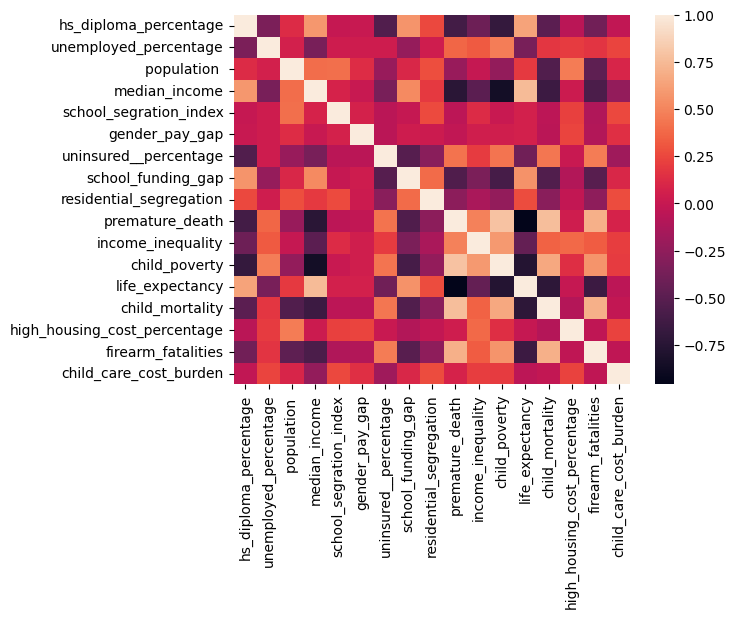

In [74]:
matrix = us_counties_updated.corr(method='spearman', numeric_only=True).round(2)
sns.heatmap(matrix)

In [75]:
us_counties_updated.describe()

,hs_diploma_percentage,unemployed_percentage,population,median_income,school_segration_index,gender_pay_gap,uninsured__percentage,school_funding_gap,residential_segregation,premature_death,income_inequality,child_poverty,life_expectancy,child_mortality,high_housing_cost_percentage,firearm_fatalities,child_care_cost_burden
count,3131.000000,3138.000000,3.131000e+03,3130.000000,2918.000000,3122.000000,3130.000000,3052.000000,2055.000000,3086.000000,3110.000000,3130.000000,3066.000000,2047.000000,3131.000000,2295.000000,3137.000000
mean,0.887595,0.035905,1.058022e+05,65489.399042,0.082087,0.786477,0.104818,-470.978545,49.466891,10380.437910,4.558839,0.190019,75.152926,64.606453,0.099764,17.800684,0.285891
std,0.054812,0.012210,3.325502e+05,16485.071600,0.075295,0.102182,0.046595,6814.750292,16.650059,3785.973079,0.810819,0.080513,3.607773,25.816667,0.033706,8.390924,0.070401
min,0.470000,0.000000,4.300000e+01,28579.000000,0.000000,0.380000,0.020000,-46776.990000,1.440000,3315.250000,2.270000,0.030000,53.980000,19.010000,0.000000,1.860000,0.120000
25%,0.860000,0.030000,1.075550e+04,54610.750000,0.030000,0.730000,0.070000,-3054.647500,38.230000,7733.415000,4.020000,0.130000,72.782500,47.065000,0.080000,12.110000,0.230000
50%,0.900000,0.030000,2.594400e+04,62771.000000,0.060000,0.790000,0.090000,20.215000,50.400000,9824.240000,4.420000,0.180000,75.270000,59.830000,0.100000,16.640000,0.280000
75%,0.930000,0.040000,6.881600e+04,73022.000000,0.110000,0.840000,0.130000,2606.035000,60.765000,12367.902500,4.957500,0.230000,77.537500,75.565000,0.120000,21.995000,0.330000
max,1.000000,0.170000,9.663345e+06,173655.000000,0.640000,1.870000,0.380000,35429.370000,92.420000,46417.850000,10.500000,0.630000,94.220000,326.690000,0.300000,79.460000,0.650000


In [101]:
us_counties_updated['population '] = us_counties_updated['population '].rename('population')

## Probability distributions

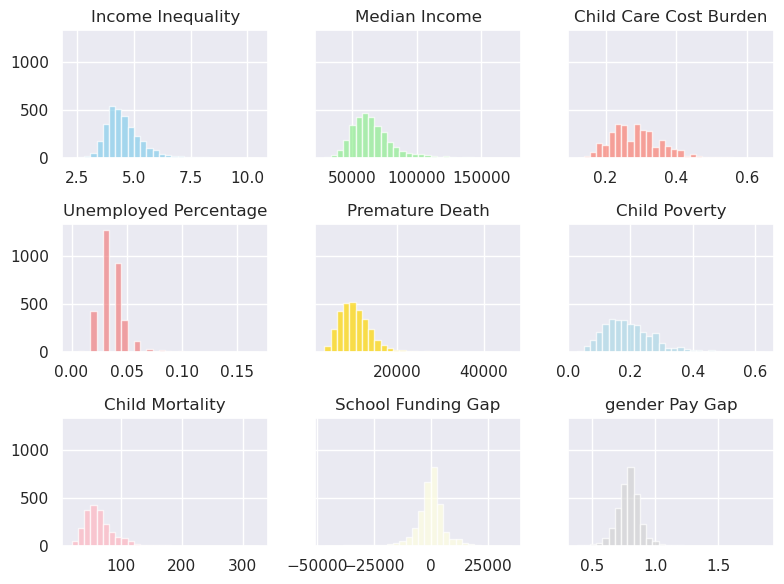

In [92]:
fig, axes = plt.subplots(3, 3, figsize=(8, 6), sharey=True)

axes[0, 0].hist(us_counties_updated['income_inequality'], bins=30, color='skyblue', alpha=0.7)
axes[0, 1].hist(us_counties_updated['median_income'], bins=30, color='lightgreen', alpha=0.7)
axes[0, 2].hist(us_counties_updated['child_care_cost_burden'], bins=30, color='salmon', alpha=0.7)
axes[1, 0].hist(us_counties_updated['unemployed_percentage'], bins=30, color='lightcoral', alpha=0.7)
axes[1, 1].hist(us_counties_updated['premature_death'], bins=30, color='gold', alpha=0.7)
axes[1, 2].hist(us_counties_updated['child_poverty'], bins=30, color='lightblue', alpha=0.7)
axes[2, 0].hist(us_counties_updated['child_mortality'], bins=30, color='lightpink', alpha=0.7)
axes[2, 1].hist(us_counties_updated['school_funding_gap'], bins=30, color='lightyellow', alpha=0.7)
axes[2, 2].hist(us_counties_updated['gender_pay_gap'], bins=30, color='lightgray', alpha=0.7)

axes[0, 0].set_title('Income Inequality')
axes[0, 1].set_title('Median Income')
axes[0, 2].set_title('Child Care Cost Burden')
axes[1, 0].set_title('Unemployed Percentage')
axes[1, 1].set_title('Premature Death')
axes[1, 2].set_title('Child Poverty')
axes[2, 0].set_title('Child Mortality')
axes[2, 1].set_title('School Funding Gap')
axes[2, 2].set_title('gender Pay Gap')
plt.tight_layout()
plt.show()

### Comparing distributions between income inequality groupings: 'above_median' and 'below_median'

In [88]:
print(us_counties_updated['income_inequality'].median())

4.42


In [90]:
us_counties_updated['income_inequality_cat'] = np.where(us_counties_updated['income_inequality'] > 4.4, 'above_median', 'below_median')
us_counties_updated['income_inequality_cat'] = us_counties_updated['income_inequality_cat'].astype('category')